In [129]:

def filter_dfs_by_metric(df_all, metric_names):
    # Names of metrics for each missing rate classification
    missing_rates_classification = [
        "roc_auc_10", "accuracy_10", "f1_score_10",
        "roc_auc_20", "accuracy_20", "f1_score_20",
        "roc_auc_30", "accuracy_30", "f1_score_30",
        "roc_auc_40", "accuracy_40", "f1_score_40",
        "roc_auc_50", "accuracy_50", "f1_score_50"
    ]

    # Filter metrics into separate lists for each category
    roc_auc_rows = [name for name in missing_rates_classification if 'roc_auc' in name]
    accuracy_rows = [name for name in missing_rates_classification if 'accuracy' in name]
    f1_score_rows = [name for name in missing_rates_classification if 'f1_score' in name]

    
    # Filter df_all to get only rows for each metric
    roc_auc_df = df_all[df_all['missing rates'].isin(roc_auc_rows)].copy()
    accuracy_df = df_all[df_all['missing rates'].isin(accuracy_rows)].copy()
    f1_score_df = df_all[df_all['missing rates'].isin(f1_score_rows)].copy()

    

    # Reset index for all DataFrames
    roc_auc_df = roc_auc_df.reset_index(drop=True)
    accuracy_df = accuracy_df.reset_index(drop=True)
    f1_score_df = f1_score_df.reset_index(drop=True)

    all_dfs = [roc_auc_df, accuracy_df, f1_score_df]

    for df in all_dfs:
        # Use a regular expression to keep only the digits at the end of each string in the column
        df['missing rates'] = df['missing rates'].str.extract(r'(\d+)$')
        df['missing rates'] = df['missing rates'].astype(int)


    # # Rename the first column in each DataFrame based on metric_names
    # roc_auc_df = roc_auc_df.rename(columns={roc_auc_df.columns[0]: f"{metric_names[0]} missing rates"})
    # accuracy_df = accuracy_df.rename(columns={accuracy_df.columns[0]: f"{metric_names[1]} missing rates"})
    # f1_score_df = f1_score_df.rename(columns={f1_score_df.columns[0]: f"{metric_names[2]} missing rates"})

    return roc_auc_df, accuracy_df, f1_score_df





In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
import os

def plot_boxplot_grid(df, image_name, plots_directory):
    # Set the style
    sns.set(style="whitegrid")



    # Melt the DataFrame for use in seaborn
    df_melted = df.melt(id_vars='missing rates', var_name='classifier', value_name='value')

    # Create a FacetGrid with boxplots instead of line plots
    g = sns.FacetGrid(df_melted, col='classifier', col_wrap=4, sharey=True, aspect=1.5)
    g.map(sns.boxplot, 'missing rates', 'value', order=sorted(df_melted['missing rates'].unique()))

    # Adjust each subplot to enhance visibility
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(45)  # Rotate x labels for better readability
        ax.set_xlabel('Missing Rates')
        ax.set_ylabel('Value')

    # Set overall titles and layout
    g.set_titles("{col_name}")
    g.fig.suptitle(f"{image_name} Values vs Missing Rates", fontsize=16)
    g.fig.subplots_adjust(top=0.92, hspace=0.3, wspace=0.4)  # Adjust spacing to fit titles and x-labels

    # Define plot directory and filename

    # Generate and save the file name
    image_file_name = f"{image_name}_boxplot_grid.png"


    # Save and show the plot
    plt.savefig(os.path.join(plots_directory, image_file_name))  # Save the plot
    plt.show()


In [131]:
import pandas as pd

def split_df_by_missing_rates(df):
    # Create a dictionary to hold the DataFrames split by missing rates
    dfs = {}
    
    # Iterate through each unique missing rate
    for rate in df['missing rates'].unique():
        # Filter the DataFrame for each unique rate and assign it to a dict
        dfs[f"df_{rate}"] = df[df['missing rates'] == rate].copy()
        
        # Reset index for cleanliness, optional
        dfs[f"df_{rate}"].reset_index(drop=True, inplace=True)

         # Drop the 'missing rates' column from the filtered DataFrame
        dfs[f"df_{rate}"].drop('missing rates', axis=1, inplace=True)
    
    return dfs



In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_mean_values(df, image_name, plots_directory):
    """
    This function plots the mean of each classifier's performance from a DataFrame as a bar graph,
    including error bars that represent the standard deviation, and saves the plot to a specified directory.
    """
    # Exclude 'missing rates' column if present
    if 'missing rates' in df.columns:
        df = df.drop(columns=['missing rates'])

    # Calculate mean and standard deviation of each column
    means = df.mean().reset_index()  # Convert series to DataFrame
    stds = df.std().reset_index()
    means.columns = ['Classifier', 'Mean Value']  # Naming the columns for clarity
    stds.columns = ['Classifier', 'STD']  # Naming the columns for clarity
    
    # Ensure there are enough colors for each classifier
    num_classifiers = len(means['Classifier'])
    colors = sns.color_palette("hsv", num_classifiers)  # Generate a color palette

    # Create the bar plot with error bars
    plt.figure(figsize=(14, 8))  # Adjust figure size as necessary
    barplot = sns.barplot(x='Classifier', y='Mean Value', data=means, palette=colors, hue='Classifier', dodge=False)
    plt.legend([],[], frameon=False)  # Hide legend

    # Add error bars manually
    for i, bar in enumerate(barplot.patches):
        bar_height = bar.get_height()
        plt.errorbar(bar.get_x() + bar.get_width() / 2, bar_height, 
                     yerr=stds.iloc[i]['STD'], capsize=10, color='black', ls='none')
    
    # Dynamically adjust the y-axis limits
    y_max = means['Mean Value'].max() + stds['STD'].max() * 1.5
    y_min = max(means['Mean Value'].min() - stds['STD'].min() * 1.5, 0)
    plt.ylim(y_min, y_max)

    plt.xticks(rotation=45, ha="right")
    plt.title(f"{image_name} vs Classifiers")  # Dynamic title
    plt.ylabel('Mean Value')
    plt.xlabel('Classifiers')
    plt.tight_layout()
    
    # Save the plot
    if not os.path.exists(plots_directory):
        os.makedirs(plots_directory)
    plt.savefig(os.path.join(plots_directory, image_name))
   

# Example usage:
# plot_mean_values(df, 'Dynamic Plot Name', '/path/to/your/plots', 'dynamic_plot.png')


In [133]:

import pandas as pd
from scipy.stats import ttest_rel
import os

def perform_and_save_ttests(df, directory):
    # Define the columns and missing rates to compare
    columns_to_test = ['Uniform Averaging', 'dew_top_None']
    comparisons = [(10, 30), (30, 50)]
    print(df.dtypes)

    # Dictionary to store the results
    results = {col: {} for col in columns_to_test}

    # Perform t-tests
    for col in columns_to_test:
        for (rate1, rate2) in comparisons:
            
            # print(df[df['missing rates'] == rate1][col])
            group1 = df[df['missing rates'] == rate1][col].dropna()
            group2 = df[df['missing rates'] == rate2][col].dropna()
            # print(group1)
            # print("========")
            # print(group2)

            if len(group1) == len(group2):  # Ensure equal sample sizes for paired t-test
                stat, p_val = ttest_rel(group1, group2)
                results[col][f'{rate1}% vs {rate2}%'] = p_val
            else:
                results[col][f'{rate1}% vs {rate2}%'] = 'n/a'  # Unequal sample sizes

    # Create a DataFrame from the results
    results_df = pd.DataFrame(results)

    # Save the DataFrame to Excel
    file_path = os.path.join(directory, 'p_values_comparison.xlsx')
    results_df.to_excel(file_path, engine='openpyxl')

    return results_df

# Example usage:
# Assuming df is your DataFrame loaded with the appropriate data
# perform_and_save_ttests(df, '/path/to/your/output/directory')



In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import os

def plot_boxplot_sig_grid(df, image_name, plots_directory):
    sns.set(style="whitegrid")

    # Melt the DataFrame for use in seaborn
    df_melted = df.melt(id_vars='missing rates', var_name='classifier', value_name='value')

    # Define the order of the missing rates explicitly
    missing_rate_order = [10, 20, 30, 40, 50]

    # Create a FacetGrid with boxplots
    g = sns.FacetGrid(df_melted, col='classifier', col_wrap=4, sharey=True, aspect=1.5)
    g.map_dataframe(sns.boxplot, x='missing rates', y='value', order=missing_rate_order)

    p_values = {}  # To store p-values

    # Perform t-tests and annotate plots
    for ax, classifier in zip(g.axes.flat, df.columns.drop('missing rates')):  # Updated to drop 'missing rates' column directly
        group_data = [df[df['missing rates'] == rate][classifier].dropna() for rate in missing_rate_order]
        p_values[classifier] = {}
        for i, data in enumerate(group_data[1:], start=1):  # Start comparisons from the second element (20%)
            if len(group_data[0]) == len(data):  # Check if sample sizes match
                stat, p_val = ttest_rel(group_data[0], data)
                p_values[classifier][f'10 vs {missing_rate_order[i]}'] = p_val
                if p_val < 0.05:
                    ax.text(i, max(data.max(), group_data[0].max()) * 1.01, '*', fontsize=15, ha='center')
            else:
                p_values[classifier][f'10 vs {missing_rate_order[i]}'] = 'n/a'  # Handle unequal sample sizes

    # Adjust subplot settings
    g.set_titles("{col_name}")
    g.set_axis_labels("Missing Rates", "Value")
    g.set_xticklabels([str(rate) for rate in missing_rate_order], rotation=45)  # Set custom tick labels
    g.fig.suptitle(f"{image_name} Values vs Missing Rates", fontsize=16)
    g.fig.subplots_adjust(top=0.92, hspace=0.3, wspace=0.4)

    # Save plot
    image_file_name = f"{image_name}_boxplot_grid.png"
    plt.savefig(os.path.join(plots_directory, image_file_name))


    # Save p-values to Excel
    p_values_df = pd.DataFrame(p_values).transpose()
    p_values_df.to_excel(os.path.join(plots_directory, f"{image_name}_p_values.xlsx"), engine='openpyxl')






In [135]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import os

def perform_plot_save_two_ttests(df,image_name, directory):
    # Define the columns and missing rates to compare
    columns_to_test = ['Uniform Averaging', 'dew_top_None']
    comparisons = [(10, 30), (30, 50)]
    means = {}
    p_values = {}

    # Dictionary to store the results, means, and p-values
    results = {col: {} for col in columns_to_test}
    for col in columns_to_test:
        means[col] = {}
        p_values[col] = {}

    # Calculate means and perform t-tests
    for col in columns_to_test:
        for rate in [10, 30, 50]:
            group = df[df['missing rates'] == rate][col].dropna()
            means[col][f'{rate}% mean'] = group.mean()

        for (rate1, rate2) in comparisons:
            group1 = df[df['missing rates'] == rate1][col].dropna()
            group2 = df[df['missing rates'] == rate2][col].dropna()

            if len(group1) == len(group2):  # Ensure equal sample sizes for paired t-test
                stat, p_val = ttest_rel(group1, group2)
                results[col][f'{rate1}% vs {rate2}%'] = p_val
                p_values[col][f'{rate1}% vs {rate2}%'] = "<0.05" if p_val < 0.05 else "NS"
            else:
                results[col][f'{rate1}% vs {rate2}%'] = 'n/a'  # Unequal sample sizes

    # Combine p-values and means in a single DataFrame
    results_df = pd.DataFrame(results)
    means_df = pd.DataFrame(means)
    combined_df = pd.concat([results_df, means_df])

    # Save the DataFrame to Excel
    file_path = os.path.join(directory, 'p_values_and_means_comparison.xlsx')
    combined_df.to_excel(file_path, engine='openpyxl')

    # Plotting means for 10%, 30%, and 50% missing rates
    fig, ax = plt.subplots()
    means_to_plot = means_df.loc[['10% mean', '30% mean', '50% mean']]
    bar_colors = ['red', 'green']  # Colors for Uniform Averaging and dew_top_None
    means_to_plot.plot(kind='bar', ax=ax, color=bar_colors)
    ax.set_title(f'{image_name} Values for 10%, 30%, and 50% Missing Rates')
    ax.set_ylabel('Mean Value')
    ax.set_xlabel('Rate')

    # Creating a table for p-values with conditional formatting
    cell_text = []
    col_labels = ['10% vs 30%', '30% vs 50%']
    for col in columns_to_test:
        cell_text.append([p_values[col][f'{10}% vs {30}%'], p_values[col][f'{30}% vs {50}%']])
    table = ax.table(cellText=cell_text,
                     rowLabels=columns_to_test,
                     colLabels=col_labels,
                     cellLoc='center',
                     rowLoc='center',
                     loc='bottom',  # Placing at the bottom to avoid overlap
                     bbox=[0.25, -0.5, 0.5, 0.3])  # Bbox to adjust location and size
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.4)  # Scaling the table to match the plot dimensions

    # Adjust y-axis
    all_values = means_to_plot.values.flatten()
    y_min, y_max = min(all_values), max(all_values)
    ax.set_ylim([y_min - 0.05 * (y_max - y_min), y_max + 0.1 * (y_max - y_min)])  # Add padding

    plt.xticks(rotation=0)
    plt.legend(title='Classifier')
    plt.tight_layout()

    # Save plot
    plot_file_path = os.path.join(directory, f'{image_name}_10_20_30_means_plot.png')
    plt.savefig(plot_file_path)


    return combined_df

# Example usage:
# perform_plot_save_two_ttests(df, '/path/to/your/output/directory')


In [136]:
import pandas as pd
import os
import os


# Define the base directory
###
base_dir        = "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Experiments/Single Extra Experiments-LimitedPipelines/diabetic_retinopathy_5-29-24_imp_pred_eval_25_trials_lmtd_pipelines/MNAR"

# List to store the paths of the desired files
file_paths = []

# Walk through the directory
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file == "final_results.csv":
            file_paths.append(os.path.join(root, file))

# Print the collected file paths
for path in file_paths:
    print(path)


'''
This is script to get data plots with signifcance testing, just copy all the full path of the final_results.csv you want into file_path below for MDEW for classification
'''
# file_paths = ["/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-07 22:10:05.847998/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-07 23:00:00.206940/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-07 23:28:21.474261/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-07 23:56:32.433629/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-08 00:23:50.655769/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-08 00:54:03.580841/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-08 01:24:46.826088/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-08 01:55:32.911953/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-08 02:26:21.662766/MCAR/final_results.csv",
#                   "/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Sig test for Cleveland MCAR/MCAR_Experiment_2024-05-08 02:26:21.662766/MCAR/final_results.csv"]

metric_names=["ROC_AUC","Accuracy","f1_score"]
missing_rates=[0.1,0.2,0.3,0.4,0.5]
###
image_name="(25 trials) Diabetic Retinopathy MNAR ROC_AUC"
###
plots_directory="/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Experiments/Single Extra Experiments-LimitedPipelines/diabetic_retinopathy_5-29-24_imp_pred_eval_25_trials_lmtd_pipelines/MNAR/Prediction Measure Plots and Data MNAR"

def append_data(all_file_paths):
    simplified_classification_names = [
    "missing rates",
    # "XGB Classifier with Bayesian",
    # "XGB Classifier with XGB",
    # "XGB Classifier with RF",
    # "XGB Classifier with KNN",
    # "RF Classifier with Bayesian",
    "RF Classifier with XGB",
    # "RF Classifier with RF",
    "RF Classifier with KNN",
    "Uniform Averaging",
    "Stacking Classifier",
    "dew_top_1",
    "dew_top_3",
    "dew_top_None"
]

    missing_rates_classification = [
    "roc_auc_10", "accuracy_10", "f1_score_10",
    "roc_auc_20", "accuracy_20", "f1_score_20",
    "roc_auc_30", "accuracy_30", "f1_score_30",
    "roc_auc_40", "accuracy_40", "f1_score_40",
    "roc_auc_50", "accuracy_50", "f1_score_50"
]
    df_all_rates= pd.DataFrame()


    for file_path in all_file_paths:
        if os.path.isfile(file_path):
            df_base = pd.read_csv(file_path)
            # Ensure the list is not longer than the DataFrame
            if len(missing_rates_classification) <= len(df_base):
                # Replace values in the first column
                df_base.iloc[:, 0] = missing_rates_classification[:len(df_base)]  
            else:
                print("Error: The replacement list has more items than the DataFrame has rows.")

            df_all_rates = pd.concat([df_all_rates, df_base], ignore_index=True)
        else:
            print(f"Error: The file {file_path} does not exist.")

    df_all_rates.rename(columns=dict(zip(df_all_rates.columns[0:], simplified_classification_names)), inplace=True)
    return df_all_rates

df_all_rates=append_data(file_paths)


roc_auc_df,accuracy_df,f1_score_df=filter_dfs_by_metric(df_all_rates, metric_names)

'''
CHOOSE THE RIGHT METRIC TO PLOT
=
=
=
=
=
=
'''

filtered_metric_df=roc_auc_df

filtered_metric_df.head(10)

/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Experiments/Single Extra Experiments-LimitedPipelines/diabetic_retinopathy_5-29-24_imp_pred_eval_25_trials_lmtd_pipelines/MNAR/MNAR_Experiment_2024-05-09 06:38:31.695269/MNAR/final_results.csv
/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Experiments/Single Extra Experiments-LimitedPipelines/diabetic_retinopathy_5-29-24_imp_pred_eval_25_trials_lmtd_pipelines/MNAR/MNAR_Experiment_2024-05-09 12:02:05.150007/MNAR/final_results.csv
/Users/dylandominguez/Library/CloudStorage/GoogleDrive-domy7912@gmail.com/My Drive/Grad School/Thesis/DylanDominguez-S24-F24-MastersThesis_Shared/MDEW/Experiments/Single Extra Experiments-LimitedPipelines/diabetic_retinopathy_5-29-24_imp_pred_eval_25_trials_lmtd_pipelines/MNAR/MNAR_Experiment_2024-05-09 23:03:2

,missing rates,RF Classifier with XGB,RF Classifier with KNN,Uniform Averaging,Stacking Classifier,dew_top_1,dew_top_3,dew_top_None
0,10,0.71698,0.71594,0.71740,0.67132,0.71832,0.71766,0.71766
1,20,0.71838,0.71376,0.72236,0.67018,0.71758,0.72174,0.72174
2,30,0.69796,0.69512,0.70338,0.66422,0.69242,0.70256,0.70256
3,40,0.70200,0.68646,0.69978,0.65548,0.69080,0.69854,0.69854
4,50,0.67246,0.63474,0.66732,0.62876,0.64690,0.66590,0.66590
5,10,0.70858,0.69342,0.70384,0.65720,0.70468,0.70430,0.70430
6,20,0.69826,0.70856,0.70748,0.66078,0.70280,0.70696,0.70696
7,30,0.69606,0.68646,0.69792,0.63422,0.69334,0.69798,0.69798
8,40,0.69636,0.66654,0.69338,0.63240,0.67590,0.69182,0.69182
9,50,0.69940,0.64258,0.68398,0.60632,0.67472,0.68338,0.68338


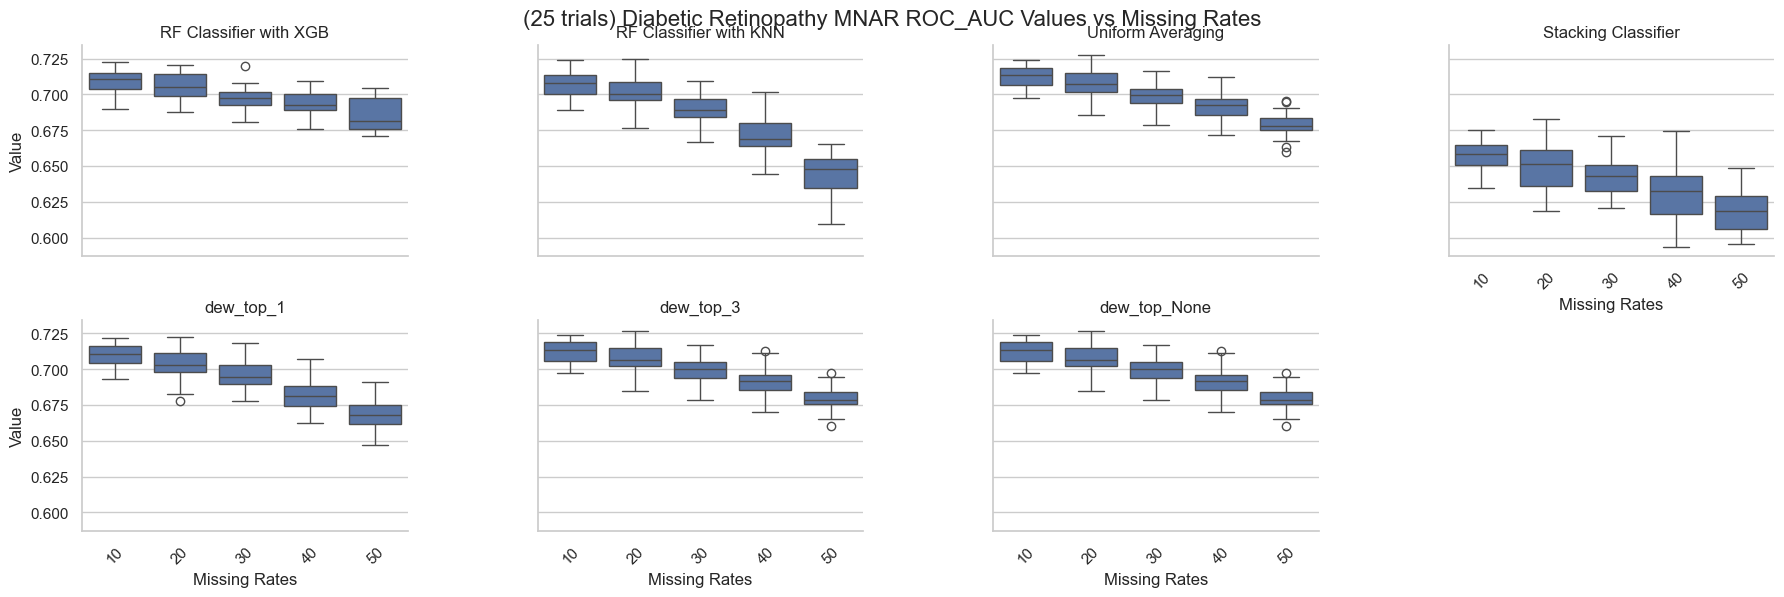

,missing rates,RF Classifier with XGB,RF Classifier with KNN,Uniform Averaging,Stacking Classifier,dew_top_1,dew_top_3,dew_top_None
0,10,0.71698,0.71594,0.71740,0.67132,0.71832,0.71766,0.71766
1,20,0.71838,0.71376,0.72236,0.67018,0.71758,0.72174,0.72174
2,30,0.69796,0.69512,0.70338,0.66422,0.69242,0.70256,0.70256
3,40,0.70200,0.68646,0.69978,0.65548,0.69080,0.69854,0.69854
4,50,0.67246,0.63474,0.66732,0.62876,0.64690,0.66590,0.66590
5,10,0.70858,0.69342,0.70384,0.65720,0.70468,0.70430,0.70430
6,20,0.69826,0.70856,0.70748,0.66078,0.70280,0.70696,0.70696
7,30,0.69606,0.68646,0.69792,0.63422,0.69334,0.69798,0.69798
8,40,0.69636,0.66654,0.69338,0.63240,0.67590,0.69182,0.69182
9,50,0.69940,0.64258,0.68398,0.60632,0.67472,0.68338,0.68338


In [137]:
plot_boxplot_grid(filtered_metric_df, image_name, plots_directory)
filtered_metric_df.head(10)

In [138]:

# Assuming roc_auc_df is already defined and loaded as per the provided format
# Example usage:
dfs = split_df_by_missing_rates(filtered_metric_df)

# Accessing individual DataFrames
df_10 = dfs['df_10']
df_20 = dfs['df_20']
df_30 = dfs['df_30']
df_40 = dfs['df_40']
df_50 = dfs['df_50']

'''
CHOOSE MISSING RATE TO PLOT
=
=
=
=
=
=
=
=

=
'''

filtered_missing_rate_df=df_50
filtered_rate_image_name=f"Missing rate 50% {image_name}"

filtered_missing_rate_df=df_50.head(10) 

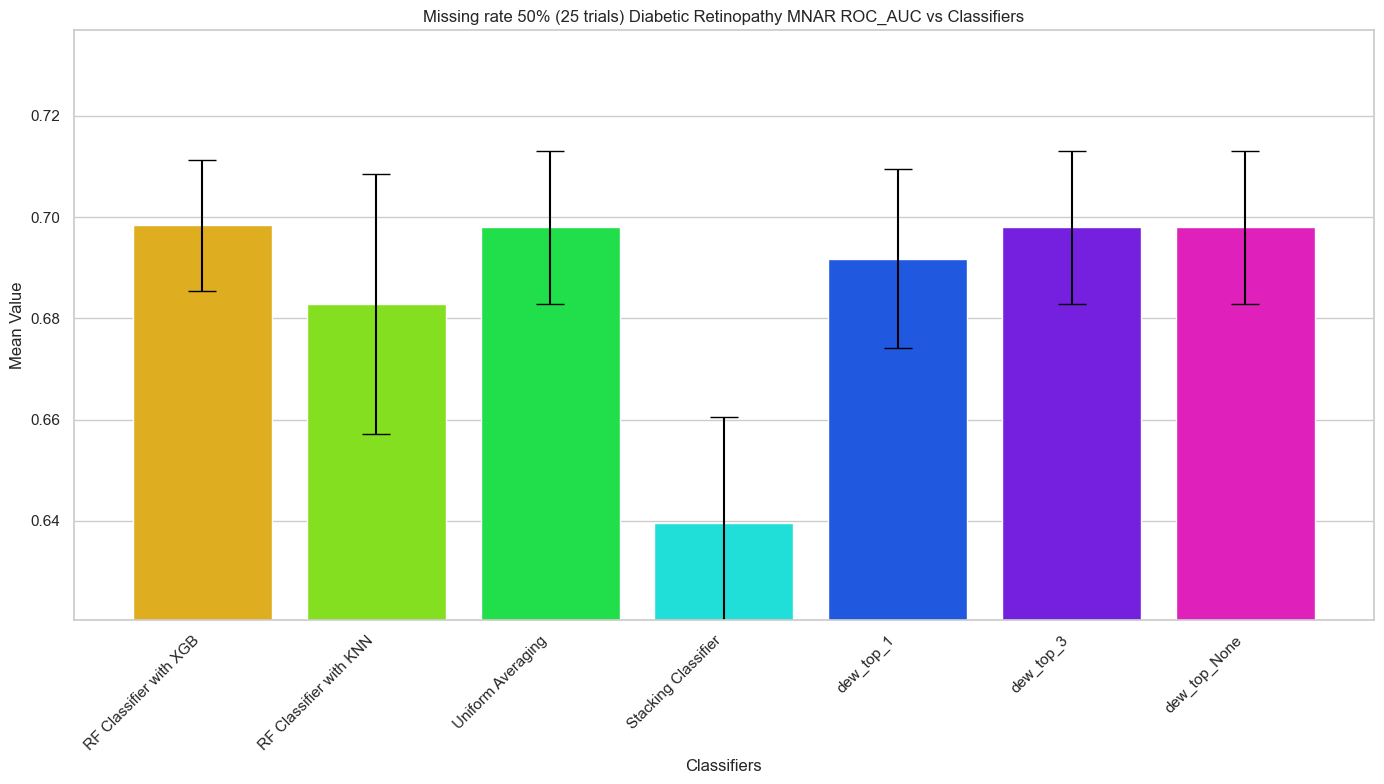

In [139]:

plot_mean_values(filtered_metric_df,filtered_rate_image_name, plots_directory)

In [140]:
perform_and_save_ttests(filtered_metric_df, plots_directory)

missing rates               int64
RF Classifier with XGB    float64
RF Classifier with KNN    float64
Uniform Averaging         float64
Stacking Classifier       float64
dew_top_1                 float64
dew_top_3                 float64
dew_top_None              float64
dtype: object


,Uniform Averaging,dew_top_None
10% vs 30%,4.038257e-06,5.581471e-06
30% vs 50%,2.921353e-08,3.128018e-08


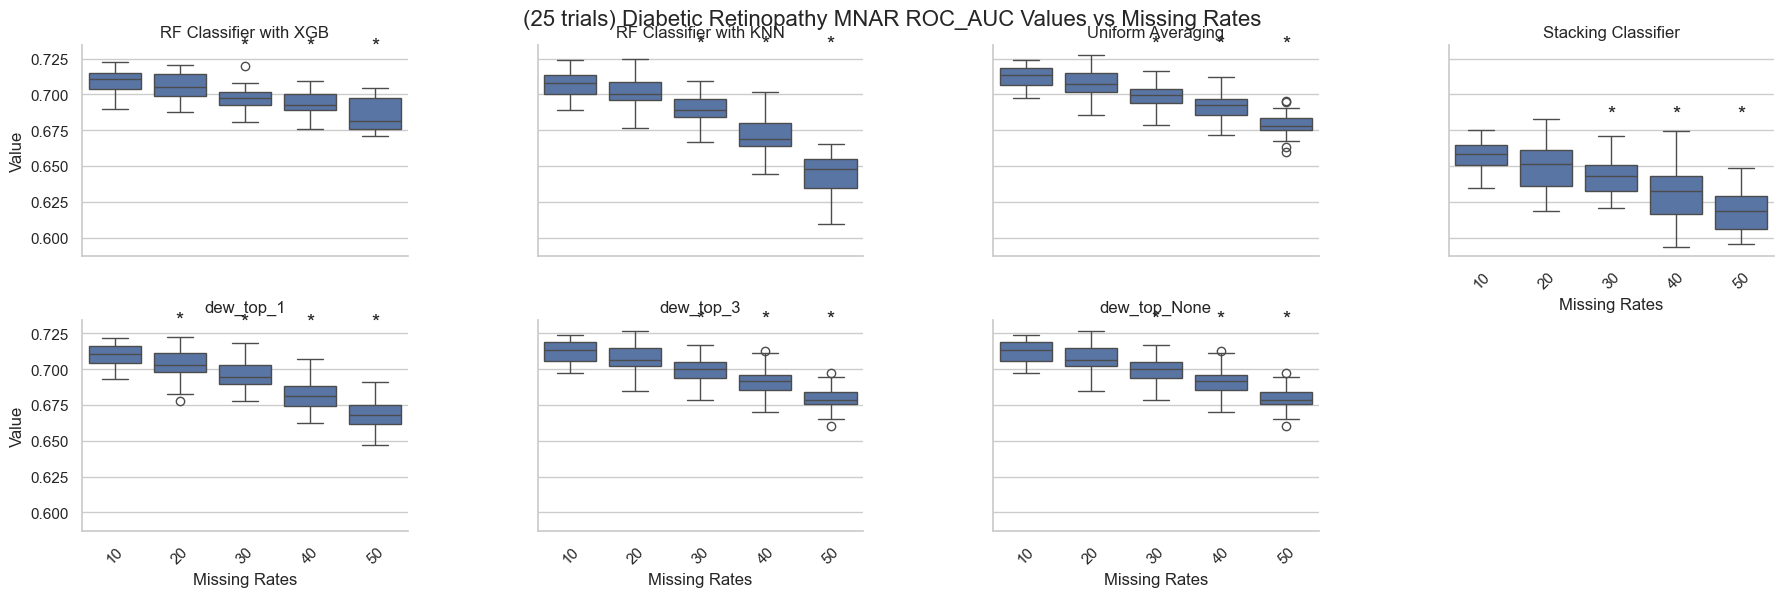

In [141]:

# Example usage
plot_boxplot_sig_grid(filtered_metric_df,image_name, plots_directory)


,Uniform Averaging,dew_top_None
10% vs 30%,4.038257e-06,5.581471e-06
30% vs 50%,2.921353e-08,3.128018e-08
10% mean,7.122064e-01,7.122016e-01
30% mean,6.995088e-01,6.995440e-01
50% mean,6.785808e-01,6.788712e-01


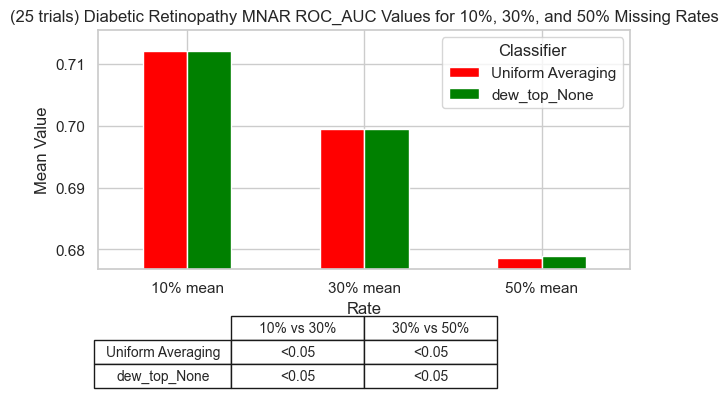

In [142]:
perform_plot_save_two_ttests(filtered_metric_df,image_name, plots_directory)